# NYC Expense Analysis

## 1 Introduction

This is an exploratory data analysis for New York expense information from 2016 to 2018. The results shown in this notebook will be used for building TripElf, an interactive map application.

### 1.1 Load Libraries

In [1]:
# settings
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon
import seaborn as sns

### 1.2 Load Dataset

In [2]:
listings = pd.read_csv("listings.csv")
expense = listings[["neighbourhood_group_cleansed","neighbourhood_cleansed","price","weekly_price","monthly_price","security_deposit","cleaning_fee","extra_people"]]
expense.head()

,neighbourhood_group_cleansed,neighbourhood_cleansed,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,Manhattan,Harlem,$59.00,$720.00,"$1,690.00",$0.00,$60.00,$39.00
1,Manhattan,Upper West Side,$140.00,$900.00,NaN,NaN,$40.00,$28.00
2,Brooklyn,Kensington,$149.00,$299.00,$999.00,$100.00,$25.00,$25.00
3,Manhattan,Midtown,$225.00,"$1,995.00",NaN,$350.00,$100.00,$0.00
4,Manhattan,Harlem,$89.00,$400.00,"$1,100.00",$100.00,$30.00,$55.00


### 1.3 Dataset structure and content

In [3]:
print("Shape of the dataset: ", expense.shape)

Shape of the dataset:  (49056, 8)


In [4]:
expense.columns

Index(['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'], dtype='object')

In [5]:
expense.dtypes

neighbourhood_group_cleansed    object
neighbourhood_cleansed          object
price                           object
weekly_price                    object
monthly_price                   object
security_deposit                object
cleaning_fee                    object
extra_people                    object
dtype: object

### 1.4 Missing Values

In [6]:
print("Number of rows of the dataset: ", len(expense))
expense.isnull().sum()

Number of rows of the dataset:  49056


neighbourhood_group_cleansed        0
neighbourhood_cleansed              0
price                               0
weekly_price                    42325
monthly_price                   43115
security_deposit                18087
cleaning_fee                    11078
extra_people                        0
dtype: int64

## 2 Feature Aggregration

In [7]:
# convert datatype
expense["price2"] = expense['price'].str.strip("$").convert_objects(convert_numeric=True)
expense["weekly_price2"] = expense['weekly_price'].str.strip("$").convert_objects(convert_numeric=True)
expense["monthly_price2"] = expense['monthly_price'].str.strip("$").convert_objects(convert_numeric=True)
expense["security_deposit2"] = expense['security_deposit'].str.strip("$").convert_objects(convert_numeric=True)
expense["cleaning_fee2"] = expense['cleaning_fee'].str.strip("$").convert_objects(convert_numeric=True)
expense["extra_people2"] = expense['extra_people'].str.strip("$").convert_objects(convert_numeric=True)

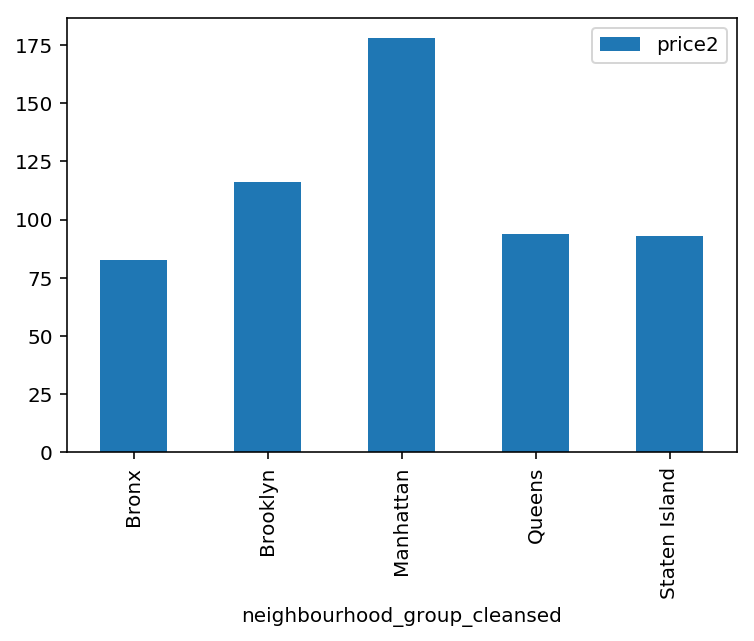

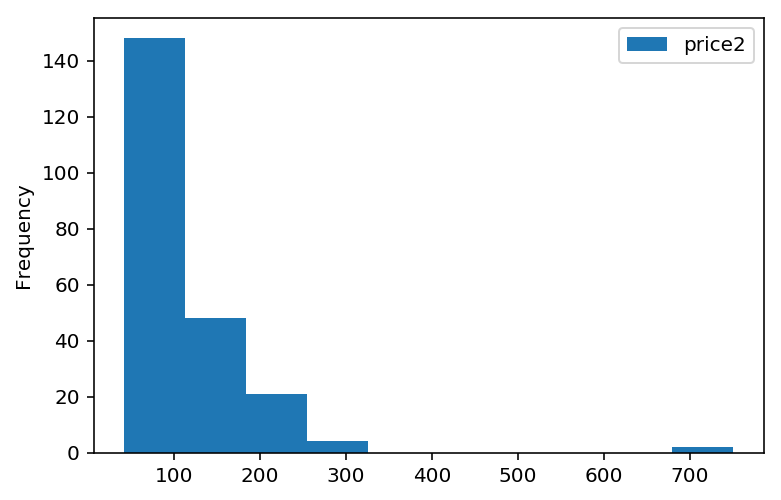

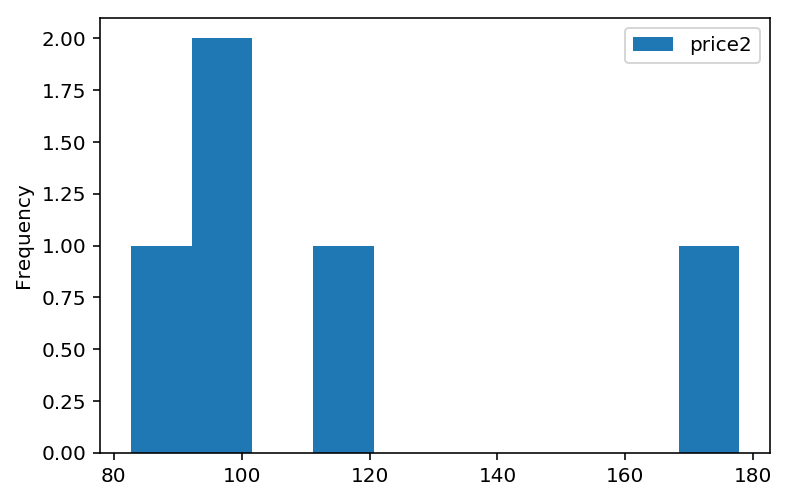

In [8]:
expense.groupby(["neighbourhood_group_cleansed"])[["price2"]].aggregate(np.mean).plot.bar()
expense.groupby(["neighbourhood_cleansed"])[["price2"]].aggregate(np.mean).plot.hist()
expense.groupby(["neighbourhood_group_cleansed"])[["price2"]].aggregate(np.mean).plot.hist()

In [9]:
# expense aggregrate

expense_agg1 = expense.groupby(["neighbourhood_cleansed"])[["price2"]].mean().reset_index()
expense_agg2 = expense.groupby(["neighbourhood_cleansed"])[["cleaning_fee2"]].mean().reset_index()
expense_agg3 = expense.groupby(["neighbourhood_cleansed"])[["extra_people2"]].mean().reset_index()
expense4 = expense[["neighbourhood_group_cleansed"]]
expense_agg = pd.concat([expense4,expense_agg1,expense_agg2["cleaning_fee2"],expense_agg3["extra_people2"]],axis = 1)
expense_agg.head()

,neighbourhood_group_cleansed,neighbourhood_cleansed,price2,cleaning_fee2,extra_people2
0,Manhattan,Allerton,89.289474,42.193548,15.605263
1,Manhattan,Arden Heights,58.000000,32.500000,22.500000
2,Brooklyn,Arrochar,109.500000,53.421053,14.500000
3,Manhattan,Arverne,157.186667,62.920635,25.533333
4,Manhattan,Astoria,100.284424,47.372549,12.856180


In [10]:
# neighborhood reference
reference = pd.read_csv("host_join.csv")
reference.head()

,neighbourhood,neighbourhood_group,superhost_count,avg_host_response_hour,avg_host_response_rate
0,Bayswater,Manhattan,0.0,2.44,0.94
1,Allerton,Manhattan,7.0,5.48,0.93
2,City Island,Brooklyn,5.0,4.09,0.92
3,Ditmars Steinway,Brooklyn,57.0,5.42,0.95
4,Ozone Park,Brooklyn,10.0,6.84,0.97


In [11]:
group = reference[["neighbourhood","neighbourhood_group"]]
group.head()

,neighbourhood,neighbourhood_group
0,Bayswater,Manhattan
1,Allerton,Manhattan
2,City Island,Brooklyn
3,Ditmars Steinway,Brooklyn
4,Ozone Park,Brooklyn


In [12]:
# expense join

expense_join = pd.merge(group, expense_agg, how='left', left_on='neighbourhood', right_on='neighbourhood_cleansed')
expense_join = expense_join[["neighbourhood","neighbourhood_group_cleansed","price2","cleaning_fee2","extra_people2"]]
expense_join = expense_join.rename(columns = {"neighbourhood":"neighbourhood","neighbourhood_group_cleansed":"neighbourhood_group","price2":"avg_price","cleaning_fee2":"avg_cleaning_fee","extra_people2":"avg_extra_people_fee"})
expense_join.head()

,neighbourhood,neighbourhood_group,avg_price,avg_cleaning_fee,avg_extra_people_fee
0,Bayswater,Manhattan,74.111111,22.142857,25.777778
1,Allerton,Manhattan,89.289474,42.193548,15.605263
2,City Island,Brooklyn,107.461538,43.333333,16.846154
3,Ditmars Steinway,Brooklyn,99.198795,45.036585,15.478916
4,Ozone Park,Brooklyn,89.755556,67.588235,10.422222


In [13]:
expense_join = expense_join.fillna(0.00)

In [14]:
expense_join.head()

,neighbourhood,neighbourhood_group,avg_price,avg_cleaning_fee,avg_extra_people_fee
0,Bayswater,Manhattan,74.111111,22.142857,25.777778
1,Allerton,Manhattan,89.289474,42.193548,15.605263
2,City Island,Brooklyn,107.461538,43.333333,16.846154
3,Ditmars Steinway,Brooklyn,99.198795,45.036585,15.478916
4,Ozone Park,Brooklyn,89.755556,67.588235,10.422222
